In [7]:
# Keras attempt
# if this works with a similar layout to 02 it means I wrote the networks
# in a bad way - which means I need to study more the math and tensorflow matrix
# config to understand it better

# keras setup is here: http://www.pyimagesearch.com/2016/11/14/installing-keras-with-tensorflow-backend/

import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
#import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, load_model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


In [15]:
TRAIN_DIR = './input-train/'
TEST_DIR = './input-test/'

ROWS = 120
COLS = 120
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
# train_images = train_dogs + train_cats
random.shuffle(train_images)
test_images =  test_images[:50]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 50
Train shape: (2000, 120, 120, 3)
Test shape: (50, 120, 120, 3)


In [17]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

#sns.countplot(labels)
#sns.plt.title('Cats and Dogs')

In [18]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

In [19]:
def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

In [24]:
epochs = 20
batch_size = 50

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        

    def on_epoch_begin(self, epoch, logs={}):
        print ('Start Training Epoch {}'.format(epoch))
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss')) 
        print('Epoch {} ended wtih {} train loss and {} validation loss'.format(
            epoch, logs.get('loss'), logs.get('val_loss')
        ))
        print('Curreny accuracy is {} training and {} validation'.format(
            logs.get('acc'), logs.get('val_acc')
        ))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    
    return history

history = run_catdog()

Start Training Epoch 0
Epoch 0 ended wtih 0.711374922593 train loss and 0.691471278667 validation loss
Curreny accuracy is 0.505333330234 training and 0.558000007272 validation
Start Training Epoch 1
Epoch 1 ended wtih 0.704701034228 train loss and 0.688522511721 validation loss
Curreny accuracy is 0.526666666071 training and 0.53599999845 validation
Start Training Epoch 2
Epoch 2 ended wtih 0.707649960121 train loss and 0.68608404398 validation loss
Curreny accuracy is 0.515333335598 training and 0.531999999285 validation
Start Training Epoch 3
Epoch 3 ended wtih 0.696130510171 train loss and 0.691494971514 validation loss
Curreny accuracy is 0.541999998689 training and 0.497999998927 validation
Start Training Epoch 4
Epoch 4 ended wtih 0.691825656096 train loss and 1.34473618269 validation loss
Curreny accuracy is 0.543333331744 training and 0.486000001431 validation
Start Training Epoch 5
Epoch 5 ended wtih 0.708502282699 train loss and 0.667939203978 validation loss
Curreny accurac

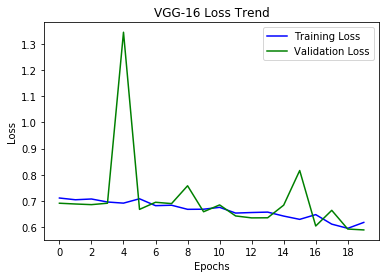

In [25]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [26]:
MODEL_PATH="./24junevnnsmall.h5"

In [30]:
model.save(MODEL_PATH)

In [31]:
def run_prediction():
    predictions = model.predict(test, verbose=0)
    print predictions
    for i in range(0,10):
        if predictions[i, 0] >= 0.5: 
            print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
        else: 
            print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

        plt.imshow(test[i])
        plt.show()


In [32]:
model = load_model(MODEL_PATH)